In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors
import os
from typing import List, Tuple, Dict
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Training

In [2]:
class KneeKeypointDataset(Dataset):
    """Dataset for loading knee point clouds and keypoint annotations."""
    
    def __init__(self, json_file: str, pointcloud_dir: str, max_points: int = 8192, 
                 surface_sampling_method: str = 'uniform', num_keypoints: int = 5):
        """
        Args:
            json_file: Path to JSON file with keypoint annotations
            pointcloud_dir: Directory containing STL mesh files
            max_points: Maximum number of points to sample from each mesh
            surface_sampling_method: 'uniform' or 'poisson' for surface sampling
            num_keypoints: Number of keypoints to use (useful for data cleaning with fewer keypoints)
        """
        with open(json_file, 'r') as f:
            self.annotations = json.load(f)
        
        self.pointcloud_dir = pointcloud_dir
        self.max_points = max_points
        self.sampling_method = surface_sampling_method
        self.num_keypoints = num_keypoints
        
        # Validate that annotations have the expected number of keypoints
        if len(self.annotations) > 0:
            expected_keypoints = len(self.annotations[0]['keypoints'])
            if expected_keypoints != num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints but found {expected_keypoints} in annotation file")
        
        # Default keypoint names (you can modify these based on your specific needs)
        self.keypoint_names = ['front', 'left', 'right', 'thigh_center', 'shin_center'][:num_keypoints]
        
    def __len__(self):
        return len(self.annotations)
    
    def load_point_cloud(self, model_id: str) -> np.ndarray:
        """Load mesh from STL file and sample points from surface."""
        mesh_path = os.path.join(self.pointcloud_dir, f"{model_id}.stl")
        
        # Load mesh from STL file
        mesh = o3d.io.read_triangle_mesh(mesh_path)
        
        # Check if mesh is valid
        if len(mesh.vertices) == 0:
            raise ValueError(f"Failed to load mesh from {mesh_path}")
        
        # Sample points from mesh surface
        # Use more points than needed for better coverage
        num_sample_points = self.max_points * 2  # Sample more than we need
        
        # Method 1: Uniform sampling
        #pcd = mesh.sample_points_uniformly(number_of_points=num_sample_points)
        
        # Alternative method 2: Poisson disk sampling (more even distribution)
        pcd = mesh.sample_points_poisson_disk(number_of_points=num_sample_points)
        
        points = np.asarray(pcd.points)
        
        # If we didn't get enough points, use fewer
        if len(points) < self.max_points:
            print(f"Warning: Only sampled {len(points)} points from mesh {model_id}")
        
        return points
    
    def find_nearest_point_indices(self, points: np.ndarray, keypoint_coords: List[List[float]]) -> List[int]:
        """Find nearest point indices for each keypoint coordinate."""
        # Use KNN to find nearest points
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(points)
        
        keypoint_indices = []
        for coord in keypoint_coords:
            distances, indices = nbrs.kneighbors([coord])
            keypoint_indices.append(indices[0][0])
        
        return keypoint_indices
    
    def normalize_point_cloud(self, points: np.ndarray) -> np.ndarray:
        """Normalize point cloud to unit sphere."""
        # Center the point cloud
        centroid = np.mean(points, axis=0)
        points = points - centroid
        
        # Scale to unit sphere
        max_distance = np.max(np.linalg.norm(points, axis=1))
        points = points / max_distance
        
        return points
    
    def sample_points(self, points: np.ndarray, keypoint_indices: List[int]) -> Tuple[np.ndarray, List[int]]:
        """Sample points while preserving keypoint indices."""
        n_points = len(points)
        
        if n_points <= self.max_points:
            # Pad with zeros if needed
            padded_points = np.zeros((self.max_points, 3))
            padded_points[:n_points] = points
            return padded_points, keypoint_indices
        
        # Always include keypoint indices in sampling
        keypoint_set = set(keypoint_indices)
        non_keypoint_indices = [i for i in range(n_points) if i not in keypoint_set]
        
        # Sample remaining points
        n_additional = self.max_points - len(keypoint_indices)
        if n_additional > 0:
            sampled_indices = np.random.choice(
                non_keypoint_indices, 
                size=min(n_additional, len(non_keypoint_indices)), 
                replace=False
            )
            all_indices = list(keypoint_indices) + list(sampled_indices)
        else:
            all_indices = keypoint_indices
        
        # Create mapping from old to new indices
        old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(all_indices)}
        new_keypoint_indices = [old_to_new[idx] for idx in keypoint_indices]
        
        return points[all_indices], new_keypoint_indices
    
    def __getitem__(self, idx: int) -> Dict:
        annotation = self.annotations[idx]
        model_id = annotation['model_id']
        
        # Load point cloud
        points = self.load_point_cloud(model_id)
        
        # Extract keypoint coordinates (only use the first num_keypoints)
        keypoint_coords = [kp['xyz'] for kp in annotation['keypoints'][:self.num_keypoints]]
        
        # Find nearest point indices
        keypoint_indices = self.find_nearest_point_indices(points, keypoint_coords)
        
        # Normalize point cloud
        points = self.normalize_point_cloud(points)
        
        # Sample points
        points, keypoint_indices = self.sample_points(points, keypoint_indices)
        
        # Create keypoint labels (one-hot encoded)
        keypoint_labels = np.zeros((self.num_keypoints, len(points)))
        for i, idx in enumerate(keypoint_indices):
            if idx < len(points):  # Safety check
                keypoint_labels[i, idx] = 1
        
        return {
            'points': torch.FloatTensor(points),
            'keypoint_labels': torch.FloatTensor(keypoint_labels),
            'model_id': model_id
        }


class PointNetFeatureExtractor(nn.Module):
    """PointNet feature extractor for point cloud processing."""
    
    def __init__(self, input_dim: int = 3, feature_dim: int = 1024):
        super().__init__()
        
        # Point-wise MLPs
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, feature_dim, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(feature_dim)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # x shape: (batch, 3, num_points)
        batch_size, _, num_points = x.size()
        
        # Point-wise feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Global feature
        global_feature = torch.max(x, 2, keepdim=True)[0]
        
        # Concatenate global and local features
        global_feature = global_feature.repeat(1, 1, num_points)
        x = torch.cat([x, global_feature], dim=1)
        
        return x


class KneeKeypointModel(nn.Module):
    """Multi-task model for knee keypoint detection."""
    
    def __init__(self, num_keypoints: int = 5, feature_dim: int = 1024):
        super().__init__()
        
        self.num_keypoints = num_keypoints
        self.feature_extractor = PointNetFeatureExtractor(feature_dim=feature_dim)
        
        # Feature dimension after concatenation
        concat_dim = feature_dim * 2
        
        # Shared layers
        self.shared_conv1 = nn.Conv1d(concat_dim, 512, 1)
        self.shared_conv2 = nn.Conv1d(512, 256, 1)
        self.shared_bn1 = nn.BatchNorm1d(512)
        self.shared_bn2 = nn.BatchNorm1d(256)
        
        # Keypoint-specific heads
        self.keypoint_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(256, 128, 1),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Conv1d(128, 1, 1)
            ) for _ in range(num_keypoints)
        ])
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # x shape: (batch, num_points, 3)
        batch_size, num_points, _ = x.size()
        
        # Transpose for conv1d
        x = x.transpose(2, 1)  # (batch, 3, num_points)
        
        # Extract features
        features = self.feature_extractor(x)
        
        # Shared processing
        x = F.relu(self.shared_bn1(self.shared_conv1(features)))
        x = F.relu(self.shared_bn2(self.shared_conv2(x)))
        x = self.dropout(x)
        
        # Keypoint predictions
        keypoint_outputs = []
        for head in self.keypoint_heads:
            output = head(x)  # (batch, 1, num_points)
            output = output.squeeze(1)  # (batch, num_points)
            keypoint_outputs.append(output)
        
        return torch.stack(keypoint_outputs, dim=1)  # (batch, num_keypoints, num_points)


class FocalLoss(nn.Module):
    """Focal loss for handling class imbalance."""
    
    def __init__(self, alpha: float = 1.0, gamma: float = 2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        # inputs: (batch, num_keypoints, num_points)
        # targets: (batch, num_keypoints, num_points)
        
        # Apply softmax to get probabilities
        #probs = F.softmax(inputs, dim=-1) #Not used anywhere...
        
        # Compute focal loss
        ce_loss = F.cross_entropy(inputs.view(-1, inputs.size(-1)), 
                                 targets.argmax(dim=-1).view(-1), 
                                 reduction='none')
        
        # Get probabilities of true class
        pt = torch.exp(-ce_loss)
        
        # Compute focal loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        return focal_loss.mean()




In [14]:
def train_model(model, 
                train_loader, 
                val_loader, 
                num_epochs: int = 100,
                learning_rate: float = 0.001, 
                device: str = 'cuda',
                weight_decay: float = 1e-4,
                focal_alpha: float = 1.0,
                focal_gamma: float = 2.0,
                save_path: str = 'best_knee_keypoint_model.pth',
                checkpoint_path: str = 'checkpoint.pth',
                load_path: str = 'best_knee_keypoint_model.pth',
                resume: bool = False):
    
    model = model.to(device)
    criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    start_epoch = 0
    best_val_loss = float('inf')

    # Resume logic
    if resume and os.path.exists(load_path):
        print("Resuming Training From Checkpoint Saved at: ", load_path)
        checkpoint = torch.load(load_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print("Loading Checkpoint with best val loss: ", best_val_loss)
        print(f"[INFO] Resumed training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0

        old_loss = """for batch_idx, batch in enumerate(train_loader):
            points = batch['points'].to(device)
            labels = batch['keypoint_labels'].to(device)

            optimizer.zero_grad()
            outputs = model(points)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            """

        
        
        # New loss, added vector relation loss func.
        for batch_idx, batch in enumerate(train_loader):
            points = batch['points'].to(device)   # (B, N, 3)
            labels = batch['keypoint_labels'].to(device)  # (B, K, N)

            optimizer.zero_grad()

            # === Forward pass ===
            outputs = model(points)               # (B, K, N)

            # === 1. Compute standard focal loss ===
            focal_loss = criterion(outputs, labels)

            # === 2. Compute pairwise vector loss ===

            # Get predicted indices
            pred_indices = torch.argmax(outputs, dim=-1)  # (B, K)

            # Get predicted XYZs
            pred_xyz = []
            for k in range(model.num_keypoints):
                idx = pred_indices[:, k]  # (B,)
                xyz = torch.stack([points[b, idx[b]] for b in range(points.size(0))])
                pred_xyz.append(xyz)
            pred_xyz = torch.stack(pred_xyz, dim=1)  # (B, K, 3)

            # Get true XYZs
            true_indices = torch.argmax(labels, dim=-1)  # (B, K)
            true_xyz = []
            for k in range(model.num_keypoints):
                idx = true_indices[:, k]
                xyz = torch.stack([points[b, idx[b]] for b in range(points.size(0))])
                true_xyz.append(xyz)
            true_xyz = torch.stack(true_xyz, dim=1)  # (B, K, 3)

           # === After you compute pred_xyz and true_xyz ===

            pairs_vector = [
                (3, 0),  # thigh → knee_center
                (0, 4),  # knee_center → shin
                (3, 4),  # thigh → shin               
                (1, 0),  # right → knee_center
                (2, 0),  # left → knee_center
                (1,2), #right → left I also want it here idk
            ]

            pairs_angle = [ (1, 2) ]  # right → left

            total_vector_loss = 0.0

            
            for a, b in pairs_vector:
                v_gt = true_xyz[:, a, :] - true_xyz[:, b, :]
                v_pred = pred_xyz[:, a, :] - pred_xyz[:, b, :]

                v_gt_norm = F.normalize(v_gt, dim=-1)
                v_pred_norm = F.normalize(v_pred, dim=-1)

                pair_loss = torch.norm(v_pred_norm - v_gt_norm, dim=-1).mean()
                total_vector_loss += pair_loss
            

            alpha = 0.5 #Weight for angle loss
            eps = 1e-6 #Epsilon to avoid division by zero for cosine similarity calculations
            for a, b in pairs_angle:
                v_gt = true_xyz[:, a, :] - true_xyz[:, b, :]
                v_pred = pred_xyz[:, a, :] - pred_xyz[:, b, :]

                v_gt_norm = F.normalize(v_gt, dim=-1)
                v_pred_norm = F.normalize(v_pred, dim=-1)

                # Cosine similarity
                cos_sim = torch.sum(v_gt_norm * v_pred_norm, dim=-1)  # (batch,)
                cos_sim = torch.clamp(cos_sim, -1.0 + eps, 1.0 - eps)

                # Angle in radians
                angles = torch.acos(cos_sim)  # (batch,)
                pair_angle_loss = angles.mean()

                total_vector_loss += pair_angle_loss * alpha


            lambda_vector = 0.1
            total_loss = focal_loss + lambda_vector * total_vector_loss



            # === 3. Backprop ===
            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()

    
            #End new code

            
            if batch_idx % 10 == 0 and True: #Turned off for now
                print(f"Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}] Loss: {total_loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                points = batch['points'].to(device)
                labels = batch['keypoint_labels'].to(device)
                outputs = model(points)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Save best model separately
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
             
             
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss
            }
            torch.save(checkpoint, checkpoint_path) # save checkpoint
            print(f"[INFO] Checkpoint saved at epoch {epoch} with val loss {best_val_loss:.4f} at location: {checkpoint_path}")
          
            torch.save(model.state_dict(), save_path) # save model
            print(f"[INFO] Best model saved at epoch {epoch} with val loss {best_val_loss:.4f} at location: {save_path}")

        # Save checkpoint every 20th epoch (not useful)
        #if epoch + 1 % 20 == 0:
        if False:
            print("Saving period checkpoint at epoch: ", epoch)
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss
            }
            torch.save(checkpoint, checkpoint_path[:-4] + f"-{epoch}.pth")

        scheduler.step()

    # Load best weights before returning
    model.load_state_dict(torch.load(save_path, map_location=device))
    print(f"[INFO] Training completed. Best model loaded from {save_path}")
    return model



def evaluate_model(model, test_loader, device: str = 'cuda'):
    """Evaluate the model and compute keypoint detection accuracy."""
    model.eval()
    model = model.to(device)
    
    total_distance_error = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for batch in test_loader:
            points = batch['points'].to(device)
            labels = batch['keypoint_labels'].to(device)
            
            outputs = model(points)
            
            # Get predicted keypoint indices
            pred_indices = torch.argmax(outputs, dim=-1)  # (batch, num_keypoints)
            true_indices = torch.argmax(labels, dim=-1)   # (batch, num_keypoints)
            
            # Compute distance error
            batch_size = points.size(0)
            for i in range(batch_size):
                for j in range(model.num_keypoints):
                    pred_point = points[i, pred_indices[i, j]]
                    true_point = points[i, true_indices[i, j]]
                    distance = torch.norm(pred_point - true_point).item()
                    total_distance_error += distance
                    total_samples += 1
    
    avg_distance_error = total_distance_error / total_samples
    print(f'Average keypoint distance error: {avg_distance_error:.4f}')
    
    return avg_distance_error


In [15]:
# Hyperparameters 
BATCH_SIZE = 32
MAX_POINTS = 8192
NUM_KEYPOINTS = 5 
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200
TRAIN_SPLIT = 0.8
SURFACE_SAMPLING_METHOD = 'uniform'  # uniform/poisson

# Focal loss hyperparam
FOCAL_ALPHA = 1.0
FOCAL_GAMMA = 2.0
WEIGHT_DECAY = 1e-4

In [16]:
JSON_FILE = 'knee_annotations/7-15-25/knee_points_aug.json'
STL_DIR = 'scans_4_aug/'
MODEL_SAVE_PATH = 'kp-selector-6.pth'

# Initialize dataset
dataset = KneeKeypointDataset(
    json_file=JSON_FILE,
    pointcloud_dir=STL_DIR,
    max_points=MAX_POINTS,
    surface_sampling_method=SURFACE_SAMPLING_METHOD,
    num_keypoints=NUM_KEYPOINTS
)

print(f"Dataset loaded with {len(dataset)} samples")
#print(f"Using {NUM_KEYPOINTS} keypoints: {dataset.keypoint_names}") #Defunct

Dataset loaded with 975 samples


In [17]:
# Split dataset
train_size = int(TRAIN_SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 780, Validation samples: 195


In [18]:
# Initialize model
model = KneeKeypointModel(num_keypoints=NUM_KEYPOINTS)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Model has {total_params:,} parameters")

# Train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on device: {device}")

Model has 1,491,461 parameters
Training on device: cuda


In [19]:
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device,
    weight_decay=WEIGHT_DECAY,
    focal_alpha=FOCAL_ALPHA,
    focal_gamma=FOCAL_GAMMA,
    save_path='kp-selector-6.pth',
    checkpoint_path='Checkpoints/checkpoint-6.pth',
    load_path = 'Checkpoints/checkpoint-6.pth',
    resume=True
)

# Evaluate model
avg_error = evaluate_model(trained_model, val_loader, device=device)
print(f"Final evaluation - Average keypoint distance error: {avg_error:.4f}")

Epoch [0/200] Batch [0] Loss: 10.0766
Epoch [0/200] Batch [10] Loss: 9.1578
Epoch [0/200] Batch [20] Loss: 9.4209
Epoch [0/200] Train Loss: 9.5083 | Val Loss: 8.8167
[INFO] Checkpoint saved at epoch 0 with val loss 8.8167 at location: Checkpoints/checkpoint-6.pth
[INFO] Best model saved at epoch 0 with val loss 8.8167 at location: kp-selector-6.pth


KeyboardInterrupt: 

In [8]:
# Save hyperparameters for reference
hyperparams = {
    'batch_size': BATCH_SIZE,
    'max_points': MAX_POINTS,
    'num_keypoints': NUM_KEYPOINTS,
    'learning_rate': LEARNING_RATE,
    'num_epochs': NUM_EPOCHS,
    'focal_alpha': FOCAL_ALPHA,
    'focal_gamma': FOCAL_GAMMA,
    'weight_decay': WEIGHT_DECAY,
    'surface_sampling_method': SURFACE_SAMPLING_METHOD
}

import json
with open('hyperparameters.json', 'w') as f:
    json.dump(hyperparams, f, indent=2)

print("Training completed! Hyperparameters saved to hyperparameters.json")

Training completed! Hyperparameters saved to hyperparameters.json


In [ ]:
# Save current checkpoint every epoch
checkpoint_path = 'checkpoint.pth'

checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'best_val_loss': best_val_loss
}
torch.save(checkpoint, checkpoint_path)


NameError: name 'epoch' is not defined

In [ ]:
if resume and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resumed training from epoch {start_epoch}")
else:
    start_epoch = 0
    best_val_loss = float('inf')


### Keypoint preditction/GT

In [9]:
def predict_keypoints_from_stl(model_path: str, 
                               stl_file: str,
                               num_keypoints: int = 2,
                               max_points: int = 8192,
                               device: str = 'cuda') -> np.ndarray:
    """
    Predict keypoint coordinates for a single STL file.

    Args:
        model_path: Path to the trained model weights (.pth).
        stl_file: Path to the input .stl mesh.
        num_keypoints: Number of keypoints your model predicts.
        max_points: Number of points to sample.
        device: 'cuda' or 'cpu'.

    Returns:
        np.ndarray of shape (num_keypoints, 3) with predicted XYZ coordinates.
    """

    # === 1. Load trained model ===
    model = KneeKeypointModel(num_keypoints=num_keypoints)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # === 2. Load and sample the mesh ===
    mesh = o3d.io.read_triangle_mesh(stl_file)
    if len(mesh.vertices) == 0:
        raise ValueError(f"Failed to load mesh: {stl_file}")
    
    num_sample_points = max_points * 2  # over-sample
    pcd = mesh.sample_points_uniformly(number_of_points=num_sample_points)
    points = np.asarray(pcd.points)

    if len(points) < max_points:
        print(f"Warning: Only {len(points)} points sampled.")
    
    # === 3. Normalize to unit sphere ===
    centroid = np.mean(points, axis=0)
    centered_points = points - centroid
    max_distance = np.max(np.linalg.norm(centered_points, axis=1))
    normalized_points = centered_points / max_distance

    # === 4. If needed, downsample to max_points ===
    if len(normalized_points) > max_points:
        indices = np.random.choice(len(normalized_points), size=max_points, replace=False)
        sampled_points = normalized_points[indices]
        orig_points = points[indices]  # save original scale for mapping back
    else:
        sampled_points = normalized_points
        orig_points = points

    # === 5. Model inference ===
    input_tensor = torch.FloatTensor(sampled_points).unsqueeze(0).to(device)  # (1, N, 3)
    preds = model(input_tensor)  # (1, num_keypoints, N)
    pred_indices = torch.argmax(preds, dim=-1).squeeze(0).cpu().numpy()  # (num_keypoints,)

    # === 6. Get predicted coordinates in world space ===
    predicted_xyz = orig_points[pred_indices]  # use un-normalized, un-centered points

    return predicted_xyz


In [31]:
# Example usage:
predicted_coords = predict_keypoints_from_stl(
    model_path='kp-selector-5.pth',
    stl_file='scans_3_aug/12408.stl',
    num_keypoints=5,
    max_points=8192,
    device='cuda'
)

#print("Predicted keypoint coordinates (XYZ):")
for i in predicted_coords:
    print(*i)


-0.04407492717906511 0.8165047945869656 -0.05809156153996659
0.05668313703475012 0.7923905421549413 -0.013162578441790772
-0.06770229629695597 0.8354252387576704 0.001751783028823705
-0.05795046648393817 0.6954033233555406 -0.05405027049426655
-0.004928895894028517 0.9598384657775556 -0.02620602100736199


In [16]:
import numpy as np
import open3d as o3d
import json
import os
from sklearn.neighbors import NearestNeighbors

In [17]:
def get_ground_truth_keypoints_original_space(scan_id, json_file, stl_dir, max_points=8192, num_keypoints=2, surface_sampling_method='uniform'):
    # Load annotations
    with open(json_file, 'r') as f:
        annotations = json.load(f)
    
    # Find annotation for this scan_id
    annotation = next((a for a in annotations if a['model_id'] == scan_id), None)
    if annotation is None:
        raise ValueError(f"No annotation found for scan id {scan_id}")
    
    # Load mesh
    mesh_path = os.path.join(stl_dir, f"{scan_id}.stl")
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    if len(mesh.vertices) == 0:
        raise ValueError(f"Failed to load mesh from {mesh_path}")
    
    # Sample points from mesh surface (original space)
    num_sample_points = max_points * 2
    if surface_sampling_method == 'uniform':
        pcd = mesh.sample_points_uniformly(number_of_points=num_sample_points)
    elif surface_sampling_method == 'poisson':
        pcd = mesh.sample_points_poisson_disk(number_of_points=num_sample_points)
    else:
        raise ValueError(f"Unknown sampling method: {surface_sampling_method}")
    points = np.asarray(pcd.points)
    
    # Get ground truth keypoint coordinates (only use the first num_keypoints)
    keypoint_coords = [kp['xyz'] for kp in annotation['keypoints'][:num_keypoints]]
    keypoint_coords = np.array(keypoint_coords)
    
    # Find nearest points in the sampled cloud to each keypoint (original space)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(points)
    indices = []
    for coord in keypoint_coords:
        _, idx = nbrs.kneighbors([coord])
        indices.append(idx[0][0])
    
    # Return the coordinates of the selected points (original mesh space)
    selected_points = points[indices]
    return selected_points

# Example usage:
# scan_id = "your_scan_id_here"
# json_file = "knee_annotations/7-2-25/knee_points_4_5_flipped.json"
# stl_dir = "scans_3/"
# selected_points = get_ground_truth_keypoints_original_space(scan_id, json_file, stl_dir)
# print(selected_points)

In [19]:
#Example usage:
scan_id = "12399"
json_file = "knee_annotations/7-11-25/knee_points_aug.json"
stl_dir = "scans_3_aug/"
selected_points = get_ground_truth_keypoints_original_space(scan_id, json_file, stl_dir)
for i in selected_points: print(*i)

0.10281439662086628 0.05239928704879306 0.4827196583086053
0.046632702911683 0.09072503956036795 0.5766313575298367


### Mesh Filtering

In [23]:
import matplotlib.pyplot as plt

In [25]:
def filter_mesh(scan_id, model_dir = "New_Architecture/saved_models/2_points_epoch_50.pth"):
    #mesh = o3d.io.read_triangle_mesh("scans_2/" + scan_id + ".stl")

    mesh = o3d.io.read_triangle_mesh("scans_3_aug/" + scan_id + ".stl")
    mesh.compute_vertex_normals()
    # Sample points on the mesh surface
    pcd = mesh.sample_points_uniformly(number_of_points=100000)  # adjust as needed

    # Create a KD-tree for the sampled point cloud
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)



    raw_points = np.asarray(pcd.points)


    print("Scan ID: " + scan_id)

    #kp1, kp2 = predict_points(model_dir, "scans_3_aug/"+ scan_id + ".stl")
    #kp1, kp2 = get_ground_truth_keypoints_original_space(scan_id, "knee_annotations/7-2-25/knee_points_4_5_aug.json", "scans_3_aug/")
    kp1, kp2 = predict_keypoints_from_stl(model_path = 'kp-selector-2.pth', stl_file = f'scans_3_aug/{scan_id}.stl', num_keypoints = 2, max_points = 8192, device = 'cuda')

     

    thigh_point = np.array(kp1)
    shin_point = np.array(kp2)

   
    axis_vec = shin_point - thigh_point
    axis_unit = axis_vec / np.linalg.norm(axis_vec)

    # Transform all points into axis coordinates
    points = np.asarray(pcd.points)

    vec_to_points = points - thigh_point  # vectors from thigh point to all points

    # Project vectors onto axis to get "height" along the axis
    heights = vec_to_points @ axis_unit  # dot product

    # Compute radial distance from axis line
    proj_points = np.outer(heights, axis_unit)  # projection vectors
    radial_vecs = vec_to_points - proj_points
    radii = np.linalg.norm(radial_vecs, axis=1)


    print(f"Max height: {np.max(heights):.2f}")
    print(f"Max radius: {np.max(radii):.2f}")

  
    # Jeet
    height_min = np.min(heights) + 0.1
    height_max = np.max(heights) - 0.15

    offset = min(0.4, np.max(radii) * 0.5)
    radius_max = np.max(radii) - offset
    radius_max = max(radius_max, 0)  # Don’t go negative



    # Create a mask for points inside cylinder
    mask = (
        (heights >= height_min) &
        (heights <= height_max) &
        (radii <= radius_max)
    )

    # Crop the point cloud
    cropped_points = points[mask]
    cropped_pcd = o3d.geometry.PointCloud()
    cropped_pcd.points = o3d.utility.Vector3dVector(cropped_points)

    print(f"axis_unit: {axis_unit}")
    print(f"heights: min={np.min(heights):.2f}, max={np.max(heights):.2f}")
    print(f"radii: min={np.min(radii):.2f}, max={np.max(radii):.2f}")
    print(f"height range: [{height_min}, {height_max}], radius_max: {radius_max}")
    print(f"Points before mask: {len(points)}, after mask: {np.sum(mask)}")


    points_cropped = np.asarray(cropped_pcd.points)


    labels = np.array(cropped_pcd.cluster_dbscan(eps=0.01, min_points=20, print_progress=True))

    unique_labels, counts = np.unique(labels[labels >= 0], return_counts=True)

    largest_cluster_label = unique_labels[np.argmax(counts)]

    indices = np.where(labels == largest_cluster_label)[0]

    cleaned_pcd = cropped_pcd.select_by_index(indices)

    print(f"After outlier removal: {len(cleaned_pcd.points)} points")




    fig = plt.figure(figsize=(10, 8))
   
   
   
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(raw_points[:, 0], raw_points[:, 1], raw_points[:, 2],
            c=raw_points[:, 2], cmap='viridis', s=0.5, alpha = 0.05)
    
    ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
    ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)


    plt.show()


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points_cropped[:, 0], points_cropped[:, 1], points_cropped[:, 2],
            c=points_cropped[:, 2], cmap='plasma', s=0.5, alpha = 0.05)
    ax.scatter(thigh_point[0], thigh_point[1], thigh_point[2], c = "r", s= 100)
    ax.scatter(shin_point[0], shin_point[1], shin_point[2], c = "r", s= 100)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()


    cleaned_points = np.asarray(cleaned_pcd.points) # Only need this for radius filtering

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(cleaned_points[:, 0], cleaned_points[:, 1], cleaned_points[:, 2],
            c=cleaned_points[:, 2], cmap='cool', s=0.5, alpha = 0.05)

    ax.set_title('Power Filtered Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(0, 1)

    plt.show()

    return cleaned_pcd


Scan ID: 12399
Max height: 0.49
Max radius: 0.71
axis_unit: [ 0.70980361  0.08139656 -0.69968095]
heights: min=-0.48, max=0.49
radii: min=0.00, max=0.71
height range: [-0.3782083267030929, 0.3356988955444723], radius_max: 0.3531497672065491
Points before mask: 100000, after mask: 63351
Precompute neighbors.[========================================] 100%
Clustering[========================================] 100%
After outlier removal: 63351 points


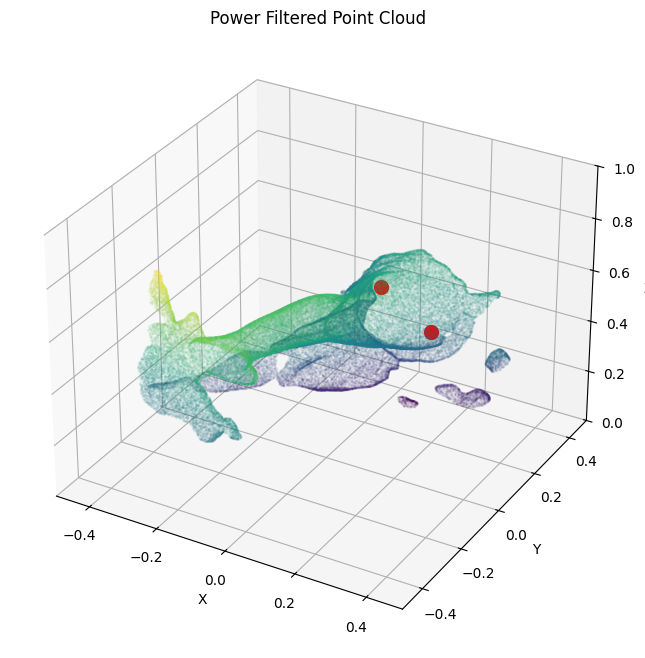

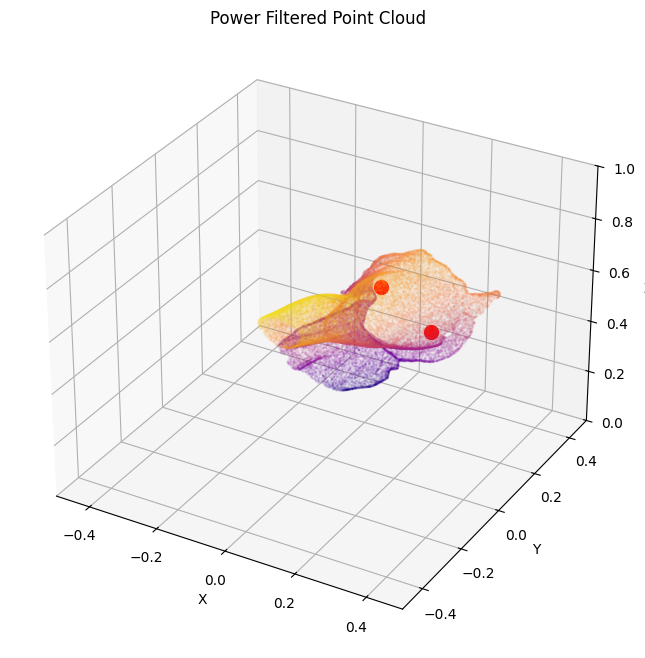

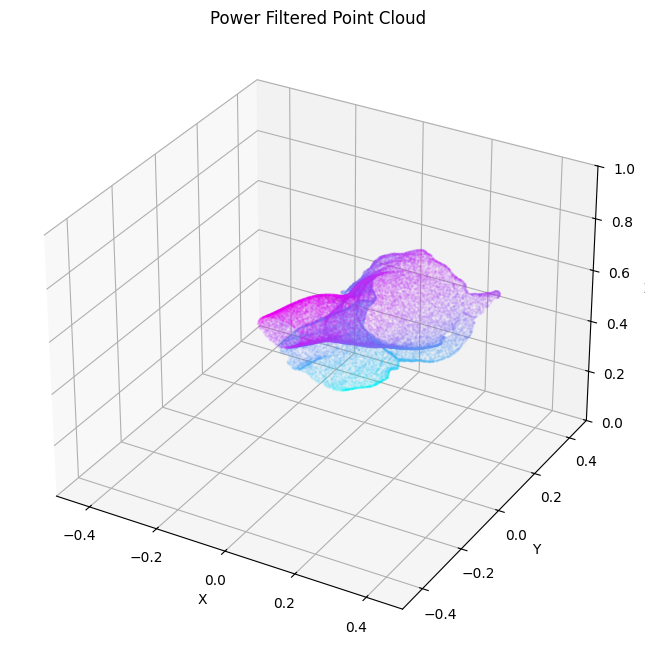

In [29]:
cleaned_pcd = filter_mesh("12399")